In [259]:
from sklearn.cluster import KMeans, MeanShift, DBSCAN
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import tensorflow as tf
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [260]:
import opendatasets as od

# token 362de83c625279a01f8399c58a63abe8
od.download("https://www.kaggle.com/datasets/arshid/iris-flower-dataset")

Skipping, found downloaded files in "./iris-flower-dataset" (use force=True to force download)


In [261]:
df = pd.read_csv('iris-flower-dataset/IRIS.csv')
df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
74,6.4,2.9,4.3,1.3,Iris-versicolor
4,5.0,3.6,1.4,0.2,Iris-setosa
113,5.7,2.5,5.0,2.0,Iris-virginica
23,5.1,3.3,1.7,0.5,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


In [262]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [263]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [264]:
X = df[["sepal_length", "sepal_width", "petal_length", "petal_width"]]
y = df['species']

In [265]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [266]:
X.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,0.428704,0.439167,0.467571,0.457778
std,0.230018,0.180664,0.299054,0.317984
min,0.000000,0.000000,0.000000,0.000000
25%,0.222222,0.333333,0.101695,0.083333
50%,0.416667,0.416667,0.567797,0.500000
75%,0.583333,0.541667,0.694915,0.708333
max,1.000000,1.000000,1.000000,1.000000


In [267]:
y.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [268]:
colors = {
    "Iris-setosa": 0,
    "Iris-versicolor": 1,
    "Iris-virginica": 2
}

In [269]:
embs = umap.UMAP().fit_transform(X)

In [270]:
kmeans = KMeans(n_clusters=3).fit(X)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [271]:
dbscan = DBSCAN(eps=0.2, min_samples=2).fit(X)

Text(0.5, 1.0, 'DBSCAN')

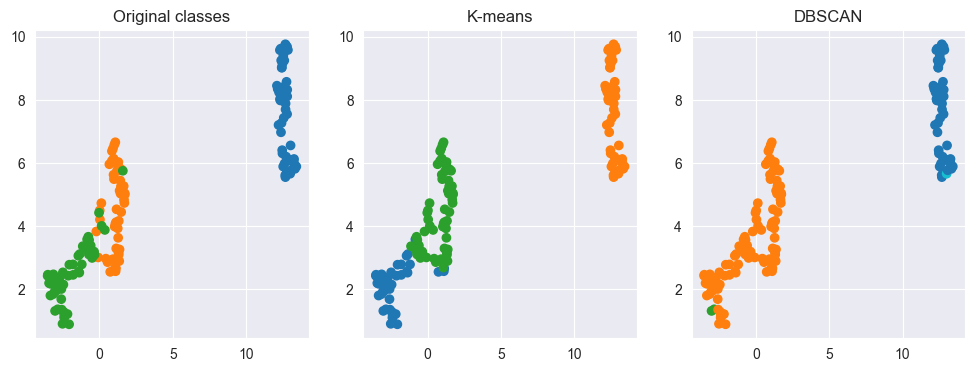

<Figure size 300x600 with 0 Axes>

In [272]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plt.figure(figsize=(3, 6))
ax1.scatter(embs[:, 0], embs[:, 1], color=[sns.color_palette()[colors[name]] for name in y])
ax1.set_title('Original classes')
ax2.scatter(embs[:,0], embs[:,1], color=[sns.color_palette()[label] for label in kmeans.labels_])
ax2.set_title('K-means')
ax3.scatter(embs[:,0], embs[:,1], color=[sns.color_palette()[label] for label in dbscan.labels_])
ax3.set_title('DBSCAN')


### Метрики качества

- Индекс Rand оценивает, насколько много из тех пар элементов, которые находились в одном классе, и тех пар элементов, которые находились в разных классах, сохранили это состояние после кластеризации алгоритмом. (внешняя тк использует правильные лейблы) 
- Davies–Bouldin Index вычисляет компактность как расстояние от объектов кластера до их центроидов, а отделимость - как расстояние между центроидами.(внутренняя)

In [273]:
def eval_metrics(labels_pred, labels, embs):
    return metrics.rand_score(labels, labels_pred), metrics.davies_bouldin_score(embs, labels_pred)

In [274]:
# k-means
eval_metrics(kmeans.labels_, y.map(colors), embs)

(0.8737360178970918, 0.5050149453608304)

In [275]:
# DBSCAN
eval_metrics(dbscan.labels_, y.map(colors), embs)

(0.7722595078299777, 0.6299893289882488)

In [276]:
def scores_plot(x, y1, y2):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].set_title("Rand score")
    axes[1].set_title("David-Bouldin score")
    axes[0].plot(x, y1)
    axes[1].plot(x, y2)

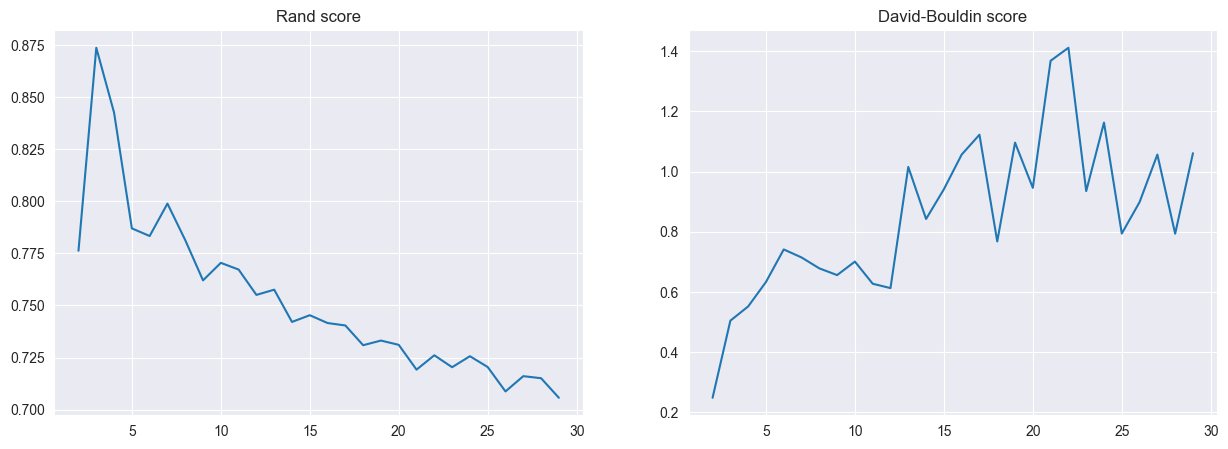

In [277]:
axis_x = []
axis_y1 = []
axis_y2 = []

for i in range(2, 30) :
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10).fit(X)
    axis_x += [i]
    y1, y2= eval_metrics(kmeans.labels_, y.map(colors), embs)
    axis_y1 += [y1]
    axis_y2 += [y2]
scores_plot(axis_x, axis_y1, axis_y2)


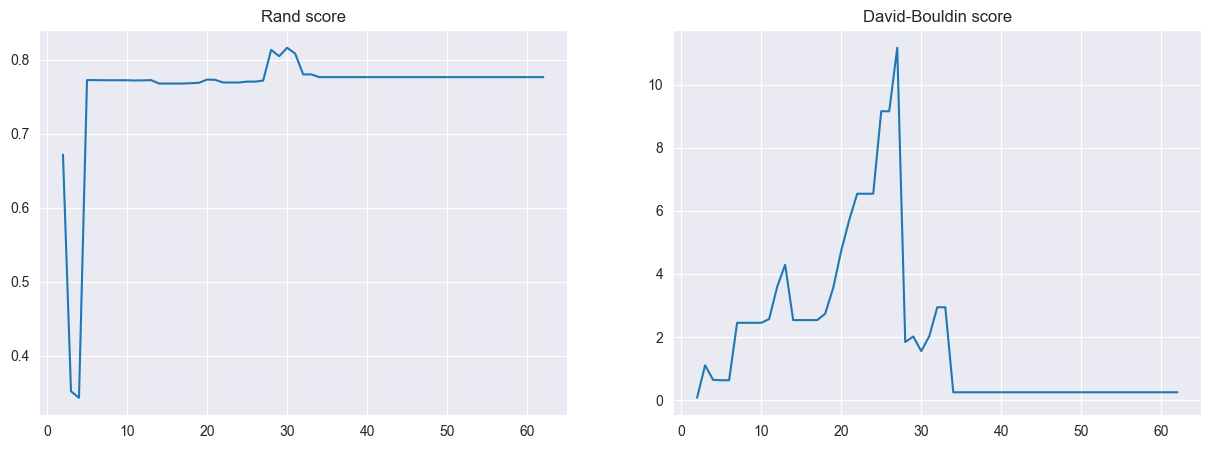

In [288]:
axis_x = list(range(2, 63))
axis_y1 = []
axis_y2 = []

for eps in np.linspace(1e-3, 10):
    for min_samples in np.arange(1, 30):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        if len(np.unique(dbscan.labels_)) == 1:
            continue
        y1, y2 = eval_metrics(dbscan.labels_, y.map(colors), embs)
        axis_y1 += [y1]
        axis_y2 += [y2]
scores_plot(axis_x, axis_y1, axis_y2)
